In [197]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns

from osrs_GE import *

pd.set_option('display.float_format', lambda x: '%.5f' % x)

---

In [4]:
# find a way to deal with dates being read in without the H M S

# /Users/codycao/Documents/Data projects/OSRS GE/osrs_GE.py:201: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
#  df['date'] = pd.to_datetime(df['date'])
item_id = 4151


df = read_item_master_file(item_id,'24h')
df.index = pd.DatetimeIndex(df.index.values,freq=df.index.inferred_freq)
df = compute_VWAP(df)
df.head()

File read successfully for Master Files/items/master_file_4151_24h.csv


C:\Users\Cody\Documents\Python Scripts\osrs ge project\osrs-ge\osrs_GE.py:201: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP
2023-09-06,1693958400,1454188,1436174,1931,1823,1445440.125
2023-09-07,1694044800,1476230,1462323,1920,1897,1469318.400
2023-09-08,1694131200,1518417,1503441,1841,2260,1510163.950
2023-09-09,1694217600,1511792,1494355,2185,2647,1502239.902
2023-09-10,1694304000,1494277,1476987,2429,2328,1485815.550


In [5]:
#df = compute_n_simple_return(df,n=7)
df['simpRet'] = (df['VWAP']/df['VWAP'].shift(1))-1
df.head(10)

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet
2023-09-06,1693958400,1454188,1436174,1931,1823,1445440.125,NaN
2023-09-07,1694044800,1476230,1462323,1920,1897,1469318.400,0.017
2023-09-08,1694131200,1518417,1503441,1841,2260,1510163.950,0.028
2023-09-09,1694217600,1511792,1494355,2185,2647,1502239.902,-0.005
2023-09-10,1694304000,1494277,1476987,2429,2328,1485815.550,-0.011
2023-09-11,1694390400,1481644,1466097,2192,2184,1473884.711,-0.008
2023-09-12,1694476800,1469447,1452185,1967,1951,1460851.247,-0.009
2023-09-13,1694563200,1450157,1428113,2289,2343,1439006.505,-0.015
2023-09-14,1694649600,1449237,1434311,2156,2077,1441913.281,0.002
2023-09-15,1694736000,1443693,1425499,2042,1918,1434880.856,-0.005


In [6]:
# create train test split
df = df.dropna()
train_idx = int(.7*df.index.shape[0])
#train_dt = df.index[train_idx]
train_dt = '2024-05-19'

df_tr = df[df.index < train_dt]
df_te = df[df.index >= train_dt]

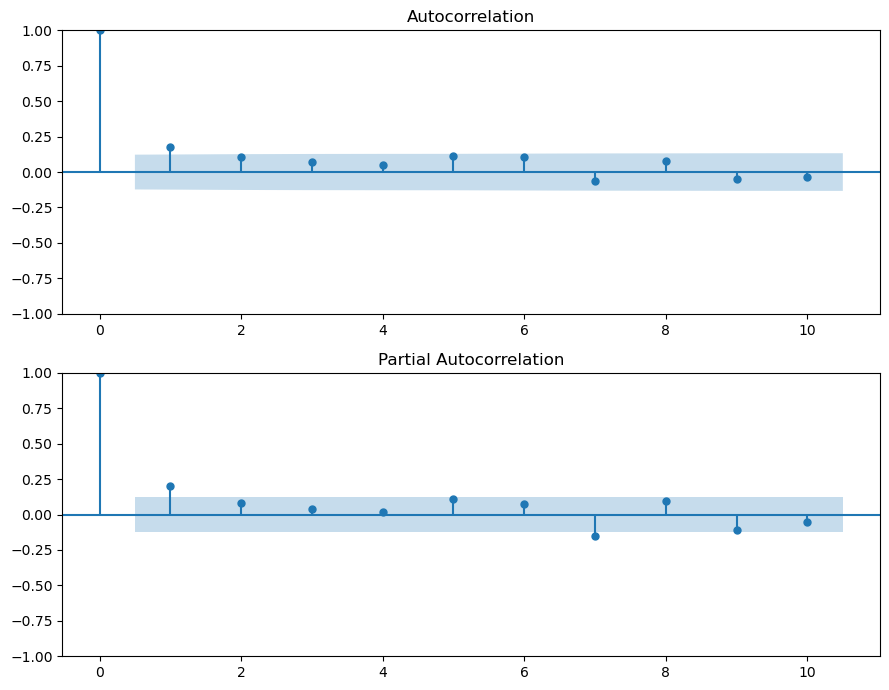

In [207]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(df_tr['simpRet'],lags=10, ax=ax[0])
plot_pacf(df_tr['simpRet'],lags=10, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

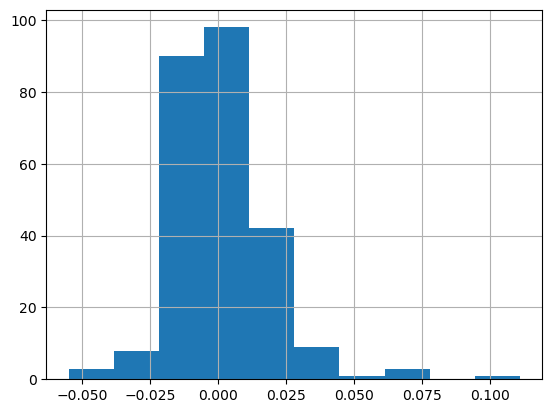

In [8]:
df_tr['simpRet'].hist()
plt.show()

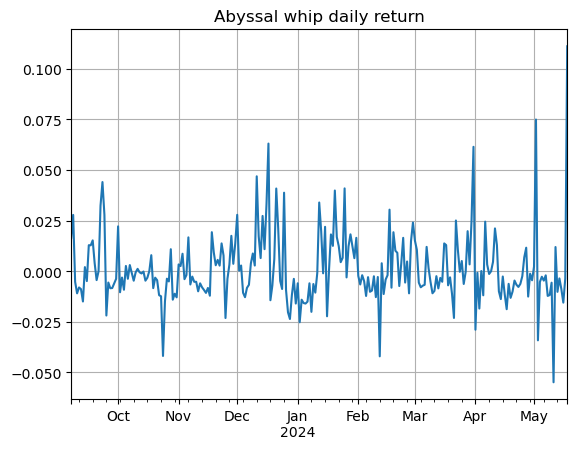

In [56]:
df_tr['simpRet'].plot()
plt.title('{} daily return'.format(item_name_from_id(item_id)))
plt.grid()
plt.show()

In [10]:
df_tr.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet
2023-09-07,1694044800,1476230,1462323,1920,1897,1469318.400,0.017
2023-09-08,1694131200,1518417,1503441,1841,2260,1510163.950,0.028
2023-09-09,1694217600,1511792,1494355,2185,2647,1502239.902,-0.005
2023-09-10,1694304000,1494277,1476987,2429,2328,1485815.550,-0.011
2023-09-11,1694390400,1481644,1466097,2192,2184,1473884.711,-0.008


In [11]:
adf_test = adfuller(df_tr['simpRet'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-11.836
p-value:0.0000
lags:0


In [12]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet'],seasonal=False,trace=True,max_p=15,max_q=15)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1338.948, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1334.826, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1342.223, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1340.734, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1341.768, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1342.695, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1340.865, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1340.997, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1340.992, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1341.357, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.518 seconds


In [14]:
P,D,Q = auto_res.order
# iterate through neighbors of optimal?
# evaluating each ARIMA order using the elliptic paraboloid function

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

res = {}
for p in range(max(1,P-1),P+2):
    for q in range(max(0,Q-1),Q+2):
        order = (p,D,q)
        print(order)
        res[order] = ARIMA_CV_SCORE(df_tr['simpRet'],order = order, start_point = max(order)+10,custom_scorer=elliptic_paraboloid_loss)

(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [15]:
for key in res:
    print('order = {}'.format(key),
          'EllipPara loss = {}'.format(res[key]['custom_scores'].mean().round(7)),
          'MAE = {}'.format(res[key]['abs_errors'].mean().round(7)),
          'MSE = {}'.format(((res[key]['errors'])**2).mean().round(7)))

order = (1, 0, 0) EllipPara loss = 0.0017311 MAE = 0.0123783 MSE = 0.0003366
order = (1, 0, 1) EllipPara loss = 0.0017332 MAE = 0.0123569 MSE = 0.0003371
order = (1, 0, 2) EllipPara loss = 0.0017515 MAE = 0.0124721 MSE = 0.0003406
order = (2, 0, 0) EllipPara loss = 0.0017419 MAE = 0.0124954 MSE = 0.0003387
order = (2, 0, 1) EllipPara loss = 0.0017681 MAE = 0.0127569 MSE = 0.0003439
order = (2, 0, 2) EllipPara loss = 0.0017773 MAE = 0.0126288 MSE = 0.0003457


Looks like ARIMA(1,0,0) and ARIMA(1,0,1) perform the best in every loss metric (elliptic paraboloid, mean absolute error, mean squared error)

In [61]:
orders = [(1,0,0),(1,0,1)]

In [67]:
for order in orders:
    print(order,'\n', res[order]['ret_df'].quantile([.35,.65]),'\n')

(1, 0, 0) 
             Pred     Real
0.35000 -0.00130 -0.00598
0.65000  0.00136  0.00277 

(1, 0, 1) 
             Pred     Real
0.35000 -0.00154 -0.00598
0.65000  0.00181  0.00277 



In [219]:
def trading_strategy(df,max_allowable = 2,start_stack = 0, signal_column = 'signal',price_column = 'VWAP_trade'):
    # df should have the signal and VWAP columns already
    inv = 0
    stack = start_stack
    
    trading_history = pd.DataFrame()
    
    for idx,row in df.iterrows():
        if row[signal_column] == 1 and inv < max_allowable:  # buy signal and we are not at inventory capacity
            stack -= row[price_column]
            inv += 1
        elif row[signal_column] == -1 and inv > 0:       # sell signal and we have positive inventory
            stack += row[price_column]
            inv -= 1
        else:
            pass
        
        trading_history.loc[idx,'inventory'] = inv
        trading_history.loc[idx,'stack'] = stack
        trading_history.loc[idx,'total_portfolio'] = stack + inv*row[price_column]
    
    trading_history['total_portfolio'].plot()
    plt.grid()
    plt.title('Portfolio value + GP')
    plt.show()

    return trading_history

(1, 0, 0)


,-1,0,1
-1,64,40,31
0,5,8,5
1,16,25,49


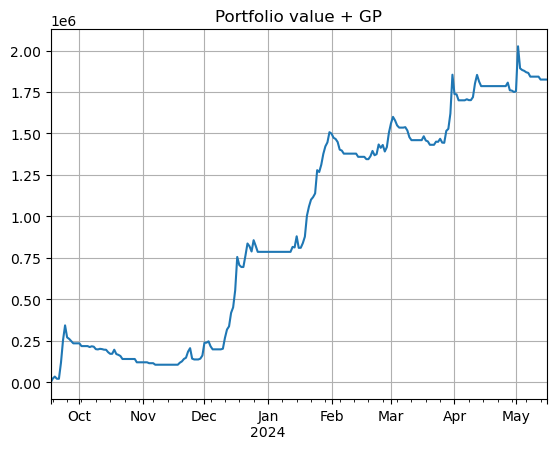

(1, 0, 1)


,-1,0,1
-1,68,36,30
0,3,9,8
1,14,28,47


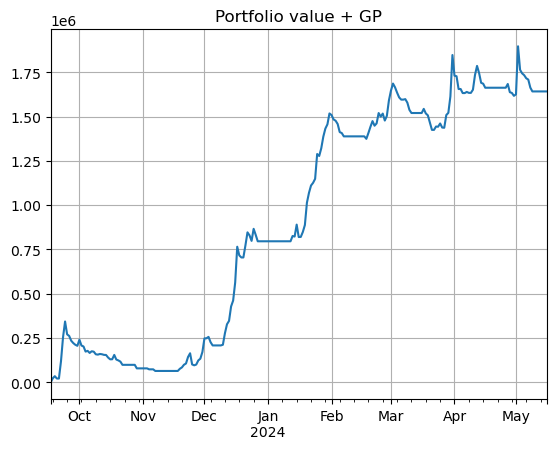

In [223]:
# naive trading strategy of selling and buying when pred is outside of the 35th and 65th percentiles
# limit to one whip

from sklearn.metrics import confusion_matrix

q_s = .35
q_b = .65

start_gp = 5e6
for order in orders:
    print(order)
    df_res = res[order]['ret_df']
    Q_s, Q_b = df_res['Pred'].quantile([q_s,q_b])
    df_res['signal'] = 1*(df_res['Pred'] >= Q_b) - 1*(df_res['Pred'] <= Q_s)
    df_res['actual'] = 1*(df_res['Real'] >= Q_b) - 1*(df_res['Real'] <= Q_s)

    df_res = df_res.merge(df_tr, how='outer',left_index=True,right_index=True)
    df_res['VWAP_trade'] = df_res['VWAP'].shift(1)
    df_res = df_res.dropna()
    df_res = df_res.drop(['timestamp','highPriceVolume','lowPriceVolume'],axis=1)
    df_res.index = df_res.index.shift(-1,df_res.index.inferred_freq)

    display(pd.DataFrame(confusion_matrix(df_res['actual'],df_res['signal']),
                        index = [-1,0,1],columns=[-1,0,1]))
    
    trading_strategy(df_res,2)